In [1]:
import os # manipulação de diretório
import pandas as pd
import shutil # manipulação de diretório
import matplotlib.pyplot as plt # plots
import cv2 # OpenCV ou cv2 para tratamento de imagens;
import numpy as np # Numpy para trabalharmos com matrizes n-dimensionais
from keras.models import Sequential # Importando modelo 
from keras.applications import ResNet101, Xception # Modelo ResNet pré treinado
from keras.layers import GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D # Camada de convolução e max pooling
from keras.layers.core import Activation, Flatten, Dense, Dropout # Camada da função de ativação, flatten, entre outros
from keras import backend as K # backend do keras
from keras.optimizers import Adam, SGD # optimizador Adam
from keras.preprocessing.image import img_to_array # Função de conversão da imagem para um vetor
from keras.utils import to_categorical # Função utilizada para categorizar listas de treino e teste
from keras.preprocessing.image import ImageDataGenerator # Classe para ajudar na variação de amostras de treinamento
from keras.callbacks import ModelCheckpoint # Classe utilizada para acompanhamento durante o treinamento onde definimos os atributos que serão considerados para avaliação
#Kaggle notebook input directory
input_path = '/kaggle/input/dataset-cats-and-dogs/cats_and_dogs/'
dst_path = '../working/'

In [2]:
def move_folder(input_folder, group_data, dst_path):
    # Função criada para trabalhar no diretório do notebook Kaggle para usufruir de sua GPU
    # Muda o dataset de diretório
    counter=0
    final_dst=os.path.join(dst_path, group_data)
    if not os.path.exists(final_dst):
        os.makedirs(final_dst)
    for group in os.listdir(input_folder):
        if os.path.isdir(os.path.join(input_folder, group)):
            group_path = os.path.join(input_folder, group)
            for img in os.listdir(group_path):
                counter+=1
                shutil.copy2(group_path+'/'+img, final_dst+'/'+img)
    print(str(counter) + "files were replaced")

In [3]:
def get_data_x_and_y(data_path, width, height, depth, classes):
    """]
    Essa função itera pelo data_path para separar dados como rotulos e
        os dados que serão utilizados para o treinamento e teste

    Args:
        data_path: O diretório com os dados
        width: Largura das matriz esperada pelo modelo
        height: Altura das matriz esperada pelo modelo
        classes: Numero de classes que o modelo utilizará

    Returns:
        Uma tupla onde na primeira posição você tem o eixo X e na segunda posição o eixo Y
    """
    labels = []
    data = []
    # itera pelo diretório
    for filename in os.listdir(data_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # faz a leitura de cada imagem
            image = cv2.imread(os.path.join(data_path, filename))
            if depth == 1:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # redimensiona a imagem
            image = cv2.resize(image, (width, height))
            # converte a imagem para um vetor
            image = img_to_array(image)
            # concatena a imagem a lista de dados que serão utilizados pelo treinamento
            data.append(image)
            # concatena a lista de rotulos a classe da imagem
            labels.append(int(filename[5])-1)
    # Normaliza os dados de treinamento
    X = np.array(data, dtype="float32") / 255.0
    # Categoriza os rotulos
    Y = to_categorical(labels, num_classes=classes)
    return (X, Y)

In [4]:
def create_lenet(input_shape):
    """
    Cria uma mini arquitetura lenet

    Args:
        input_shape: Uma lista de três valores inteiros que definem a forma de\
                entrada da rede. Exemplo: [100, 100, 3]

    Returns:
        Um modelo sequencial, seguindo a arquitetura lenet
    """
    # Definimos que estamos criando um modelo sequencial
    model = Sequential()

    # Primeira camada do modelo:
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Segunda camada do modelo:
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Primeira camada fully connected
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # Classificador softmax
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

In [5]:
def create_model_2(input_shape):
    """
    Modelo baseado na LeNet
    Acréscimo de um layer convolucional 3x3 na segunda camada da rede.
    """
    # Definimos que estamos criando um modelo sequencial
    model = Sequential()

    # Primeira camada do modelo:
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Segunda camada do modelo:
    model.add(Conv2D(50, (3, 3), padding="same")) # Layer adicionado
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Primeira camada fully connected
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # Classificador softmax
    model.add(Dense(2))
    model.add(Activation("softmax"))
    return model

In [6]:
def create_model_3(input_shape):
    """
    Cria um modelo com a arquitetura Xception do projeto Image Net, já pré treinada
    Técnica conhecida como Transfer Learning
    """
    
    # Definimos que estamos criando um modelo sequencial
    model = Sequential()

    base = Xception(weights="imagenet", include_top=False) ## Modelo base
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(250, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))

    return model

In [7]:
def plot_accs(result, epochs):
    # Plota válores da acurácia de treino/validação
    # plota valores do loss para treino/validação
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 20)      520       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 20)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 31250)             0

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


625/625 [==============================] - 28s 37ms/step - loss: 0.6939 - accuracy: 0.5450 - val_loss: 0.6570 - val_accuracy: 0.6124
Epoch 2/10
625/625 [==============================] - 23s 37ms/step - loss: 0.6610 - accuracy: 0.6040 - val_loss: 0.6178 - val_accuracy: 0.6638
Epoch 3/10
625/625 [==============================] - 23s 37ms/step - loss: 0.6301 - accuracy: 0.6428 - val_loss: 0.5674 - val_accuracy: 0.7092
Epoch 4/10
625/625 [==============================] - 23s 36ms/step - loss: 0.5885 - accuracy: 0.6878 - val_loss: 0.5329 - val_accuracy: 0.7296
Epoch 5/10
625/625 [==============================] - 23s 36ms/step - loss: 0.5597 - accuracy: 0.7095 - val_loss: 0.4818 - val_accuracy: 0.7690
Epoch 6/10
625/625 [==============================] - 23s 37ms/step - loss: 0.5323 - accuracy: 0.7373 - val_loss: 0.4718 - val_accuracy: 0.7756
Epoch 7/10
625/625 [==============================] - 23s 37ms/step - loss: 0.5210 - accuracy: 0.7427 - val_loss: 0.4435 - val_accuracy: 0.7874
Epo

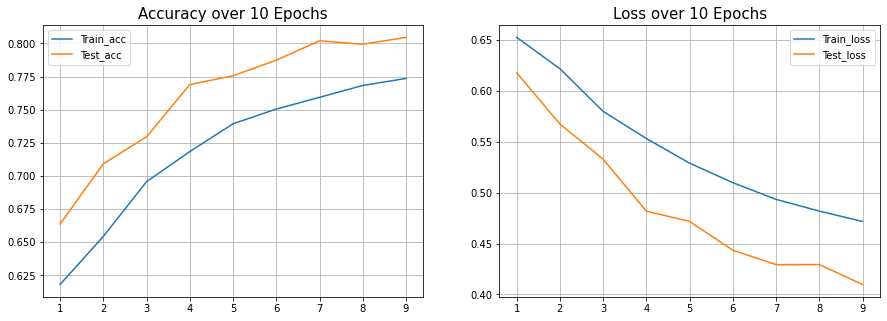


 training network 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 20)      520       
_________________________________________________________________
activation_4 (Activation)    (None, 128, 128, 20)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 50)        9050      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 50)        62550     
_________________________________________________________________
activation_5 (Activation)    (None, 64, 64, 50)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (Non

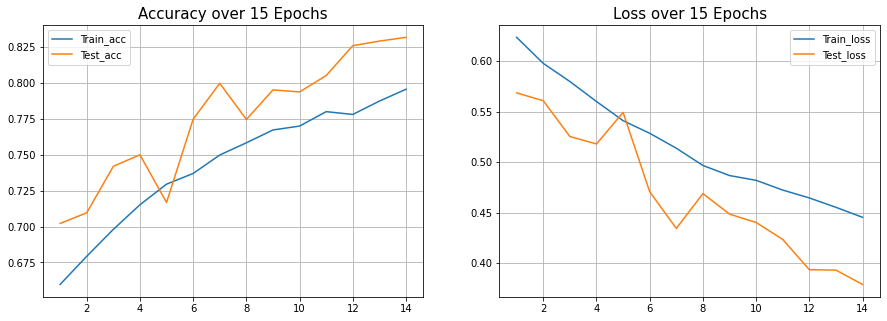

83689472/83683744 [==============================] - 1s 0us/step

 training network 3
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               512250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
__________________________________

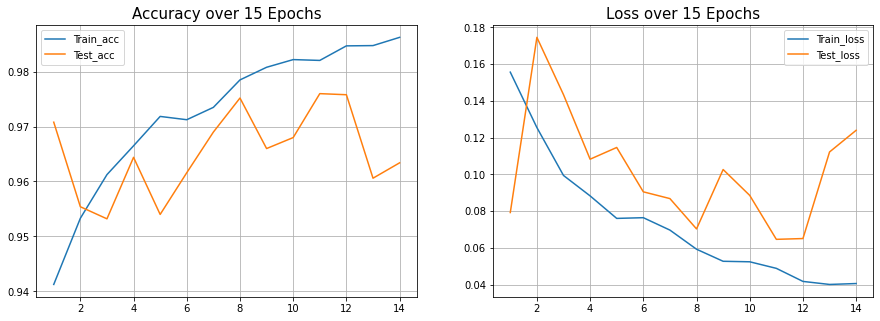

In [8]:
if __name__ == '__main__':
    train_path = os.path.join(input_path, 'train/') # Adicione aqui o caminho para chegar no diretório que contém as imagens de treino na sua maquina
    test_path = os.path.join(input_path, 'test/') # Adicione aqui o caminho para chegar no diretório que contém as imagens de teste na sua maquina
    models_path = os.path.join(dst_path, 'model/') # Defina aqui onde serão salvos os modelos na sua maquina
    width = 100 # Tamanho da largura da janela que será utilizada pelo modelo
    height = 100 # Tamanho da altura da janela que será utilizada pelo modelo
    depth = 1 # Profundidade das janelas utilizadas pelo modelo, caso seja RGB use 3, caso escala de cinza 1
    classes = 2 # Quantidade de classes que o modelo utilizará
    epochs = 10 # Quantidade de épocas (a quantidade de iterações que o modelo realizará durante o treinamento)
    init_lr = 1e-3 # Taxa de aprendizado a ser utilizado pelo optimizador
    batch_size = 32 # Tamanho dos lotes utilizados por cada epoca
    input_shape = (height, width, depth) # entrada do modelo
    save_model = os.path.join(models_path, "lenet-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.model")
    os.makedirs(models_path, exist_ok=True)

    # Treinando rede LeNet dada
    (trainX, trainY) = get_data_x_and_y(train_path, width, height, depth, classes)
    (testX, testY) = get_data_x_and_y(test_path, width, height, depth, classes)

    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                fill_mode="nearest")

    model = create_lenet(input_shape)

    opt = Adam(lr=init_lr, decay=init_lr / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()

    print("\n training network 1")

    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
            validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
            epochs=epochs, verbose=1)
    
    plot_accs(H, epochs)
    
    df = pd.DataFrame.from_dict(H.history)
    df.to_csv(dst_path + "lenet.csv", index=False)    
        
    ## Treinando segunda arquitetura
     # - Mudança: Width, heigth, depth e epochs
        # Mudança: Acréscimo de um layer Convolucional 3x3 na seguda camada
    
    width = 128 # Tamanho da largura da janela que será utilizada pelo modelo
    height = 128 # Tamanho da altura da janela que será utilizada pelo modelo
    depth = 1 # Tamanho da largura da janela que será utilizada pelo modelo
    epochs = 15 # Quantidade de épocas
    input_shape = (height, width, depth) # entrada do modelo

    save_model = os.path.join(models_path, "model2-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.model")
    (trainX, trainY) = get_data_x_and_y(train_path, width, height, depth, classes)
    (testX, testY) = get_data_x_and_y(test_path, width, height, depth, classes)

    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                fill_mode="nearest")

    model = create_model_2(input_shape)

    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    
    print("\n training network 2")

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()

    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
            validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
            epochs=epochs, verbose=1)
    
    plot_accs(H, epochs)
    
    df = pd.DataFrame.from_dict(H.history)
    df.to_csv(dst_path + "model2.csv", index=False)    
    
    ## Treinando terceira arquitetura
    # Mudança - Modelo Xception
    depth = 3 # Profundidade mudada - escala RGB
    input_shape = (height, width, depth) # entrada do modelo
    save_model = os.path.join(models_path, "model3-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.model")
    os.makedirs(models_path, exist_ok=True)

    (trainX, trainY) = get_data_x_and_y(train_path, width, height, depth, classes)
    (testX, testY) = get_data_x_and_y(test_path, width, height, depth, classes)

    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                fill_mode="nearest")
    opt = Adam(lr=init_lr, decay=init_lr / epochs)

    model = create_model_3(input_shape)
    
    print("\n training network 3")

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()

    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
            validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
            epochs=epochs, verbose=1)
    
    plot_accs(H, epochs)
    
    df = pd.DataFrame.from_dict(H.history)
    df.to_csv(dst_path + "model3.csv", index=False)